## Legrövidebb út

Egy 6 települést összekötő, egyirányú úthálózaton szeretnénk megtalálni a legrövidebb utat az 1-es településből a 6-osba. A településeket az alábbi útszakaszok kapcsolják össze:

$$
\begin{array}{c|c|c}
\text{Honnan} & \text{Hová} & \text{Távolság} \\ \hline
1 & 2 & 16 \\
1 & 3 & 32 \\
2 & 4 & 7 \\
2 & 5 & 35 \\
3 & 5 & 12 \\
4 & 3 & 8 \\
4 & 6 & 27 \\
5 & 6 & 6
\end{array}
$$

Egy LP segítségével is meg tudjuk határozni a legrövidebb utat. A feladat formalizációját a következőképp tudnánk szemléltetni.
* Vegyünk 6 fémgolyót, melyek a 6 települést reprezentálják
* Ha két települést egy $k$ hosszú út kapcsol össze, akkor kössük össze őket egy $k$ hosszú madzaggal
* Ezt követően az 1-es és 6-os fémgolyóknál fogva feszítsük ki az összekötött 'hálózatot'
* Bizonyos összeköttetések feszesek lesznek, bizonyos madzagokban némi többlet szabadon fog lógni
* (Az is elképzelhető, hogy a szabadon lógó madzagokon bizonyos fémgolyók is megtalálhatóak majd)
* A feszes madzagok által reprezentált útszakaszok meghatározzák a legrövidebb utat

Formálisan: Jelölje $x_1, \dots, x_6$ változók az egyes települések 1-es településtől vett távolságát.
* Minden közvetlen kapcsolat esetén a két város távolsága legalább az őket összekötő út hossza
* (elvileg lehetséges, hogy a közvetlen kapcsolatnál van rövidebb közvetett, más városokon át vezető út)
* Azaz mivel az 1-es és 2-es város között az út hossza 16: $x_2 - x_1 \leq 16$
* (a madzagok úgymond 'irányítottak', erre figyelnünk kell az egyenlőetlenségeknél)
* Ezeket megadjuk a gráf minden élére, azaz egészen $x_6 - x_5 \leq 6$-ig

A változó definícióból következően rögzítjük az 1-es fémgolyó pozícióját: $x_1 = 0$.
<br> Már csak a célfüggvény van hátra, mely magát a kifeszítést jelenti: $\max x_6$

{(1, 2): Text(-0.6077675770426422, 0.004462910311796381, '16'),
 (1, 3): Text(-0.6053620321273759, 0.19510577292558248, '32'),
 (2, 4): Text(-0.014167392364793224, -0.11344356585017829, '7'),
 (2, 5): Text(-0.07331733171018774, 0.011059487077237348, '35'),
 (3, 5): Text(-0.07091178679492154, 0.20170234969102346, '12'),
 (4, 3): Text(-0.011761847449527019, 0.07719929676360782, '8'),
 (4, 6): Text(0.6786793638375646, -0.20616526000281946, '27'),
 (5, 6): Text(0.61952942449217, -0.08166220707540381, '6')}

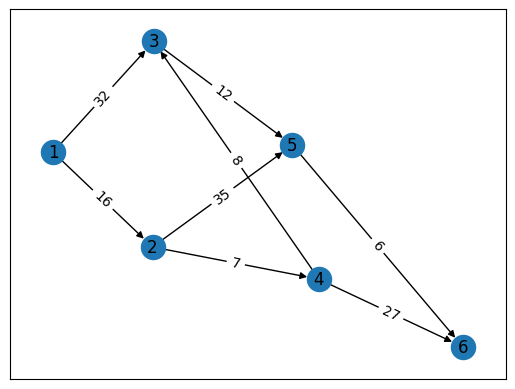

In [1]:
import networkx as nx
G = nx.DiGraph()
G.add_nodes_from(range(1,7))
G.add_edge(1, 2, weight = 16)
G.add_edge(1, 3, weight = 32)
G.add_edge(2, 4, weight = 7)
G.add_edge(2, 5, weight = 35)
G.add_edge(3, 5, weight = 12)
G.add_edge(4, 3, weight = 8)
G.add_edge(4, 6, weight = 27)
G.add_edge(5, 6, weight = 6)
pos = nx.spring_layout(G, seed=6)
nx.draw_networkx(G, pos, with_labels=True)
edge_labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels)

In [2]:
from pulp import *

rovidut_LP = pulp.LpProblem('Legrövidebb_út', LpMaximize)

x = LpVariable.dicts('x',range(1, 7),cat="Continuous")
# ezúttal 1-től indítom a változók indexálását, mert a gráfban is 1-től indexáltuk a csúcsokat

# célfüggvény:
rovidut_LP += x[6]

# élsúlyok kiolvasása a gráfból a korlátokhoz: 
d = nx.get_edge_attributes(G, 'weight')
# éllista:
elek = list(G.edges())

for i in range(len(elek)): # élek számán iterálunk
    # i-dik él kezdőpontja: elek[i][0]
    # i-dik él végpontja: elek[i][1]
    # ekkor az i-dik él súlya: d[elek[i][0], elek[i][1]]
    rovidut_LP += x[elek[i][1]] - x[elek[i][0]] <= d[elek[i][0], elek[i][1]]

rovidut_LP += x[1] == 0
# csak a szemléletesség kedvéért: nincs is szükség erre a változóra, de akkor külön kéne kezelni az 1-ből induló éleket

megoldas = rovidut_LP.solve()

print(LpStatus[megoldas])
print('Legrövidebb út hossza: z* = ', value(rovidut_LP.objective))
for v in rovidut_LP.variables(): # a változók értékét az optimális megoldásban iteratívan meghatározzuk
    print (v.name, "=", v.varValue)

Optimal
Legrövidebb út hossza: z* =  49.0
x_1 = 0.0
x_2 = 16.0
x_3 = 31.0
x_4 = 23.0
x_5 = 43.0
x_6 = 49.0


Honnan tudjuk, hogy merre vezet a legrövidebb út?

In [3]:
i=0
for name, c in rovidut_LP.constraints.items():
    print('y'+str(elek[i])+' =', c.pi)
    i += 1
    if (i == len(elek)):
        break

y(1, 2) = 1.0
y(1, 3) = -0.0
y(2, 4) = 1.0
y(2, 5) = -0.0
y(3, 5) = 1.0
y(4, 3) = 1.0
y(4, 6) = -0.0
y(5, 6) = 1.0


Az LP formalizmussal választ adhatunk olyan kérdésekre, melyre a gráfos algoritmus önmagában nem tud. Például meddig kéne csökkenjen a 4 és 6 közötti távolság ahhoz, hogy bekerüljön a legrövidebb útba?

In [4]:
# új, ezúttal minimalizálandó célfüggvény:
rovidut_LP += x[4] - x[6]
# a 4-ből 6-ba vezető távolságot (x[6] - x[4]) akarjuk minimalizálni
# vagyis vagy új modellt adunk meg a minimalizálás miatt, vagy az (x[4] - x[6])-ot maximalizáljuk

# a legrövidebb út mentén rögzítjük a távolságokat:
rovidut_LP += x[2] - x[1] == 16
rovidut_LP += x[4] - x[2] == 7

rovidut_LP += x[5] - x[3] == 12
rovidut_LP += x[3] - x[4] == 8
rovidut_LP += x[6] - x[5] == 6

megoldas = rovidut_LP.solve()

print(LpStatus[megoldas])
print('4 és 6 távolsága legfeljebb, hogy része legyen a legrövidebb útnak:', -value(rovidut_LP.objective))

Optimal
4 és 6 távolsága legfeljebb, hogy része legyen a legrövidebb útnak: 26.0


C:\Users\balaz\AppData\Local\Programs\Python\Python311\Lib\site-packages\pulp\pulp.py:1704: UserWarning: Overwriting previously set objective.
  warnings.warn("Overwriting previously set objective.")


1.feladat: Határozzuk meg a legrövidebb utat az S csúcsból a T csúcsba az alábbi irányított élekkel adott hálózatban:

$$
\begin{array}{c|c|c}
\text{Honnan} & \text{Hová} & \text{Távolság} \\ \hline
S & A & 8 \\
S & B & 9 \\
A & C & 7 \\
A & D & 11 \\
B & E & 17 \\
C & B & 2 \\
C & D & 4 \\
D & T & 13 \\
D & E & 4 \\
E & T & 6 
\end{array}
$$

a) Határozzuk meg a legrövidebb utat és hosszát a Dijkstra algoritmus segítségével!
<br> b) Adjuk meg a legrövidebb utat meghatározó LP modelljét pulpban. Oldjuk meg és határozzuk meg a legrövidebb utat!
<br> c) Milyen C-T távolság esetén érné meg kiépíteni a C-T élt?

{('s', 'a'): Text(0.8117449049695933, 0.39091574665765266, '8'),
 ('s', 'b'): Text(0.38873954709122704, 0.48746394302286616, '9'),
 ('a', 'c'): Text(-0.13873948748658427, 0.6078576472705552, '7'),
 ('a', 'd'): Text(-0.13873948748658427, 0.1739738758470714, '11'),
 ('b', 'e'): Text(-0.22252093561986735, 8.514949023652463e-09, '17'),
 ('c', 'b'): Text(-0.5617448453649505, 0.7044058436357687, '2'),
 ('c', 'd'): Text(-0.9009687849123551, 3.8317270328880326e-08, '4'),
 ('d', 't'): Text(-0.13873957689354838, -0.6078576600429786, '13'),
 ('d', 'e'): Text(-0.5617448751672719, -0.7044057968035494, '4'),
 ('e', 't'): Text(0.20048433285153483, -0.8783797237403146, '6')}

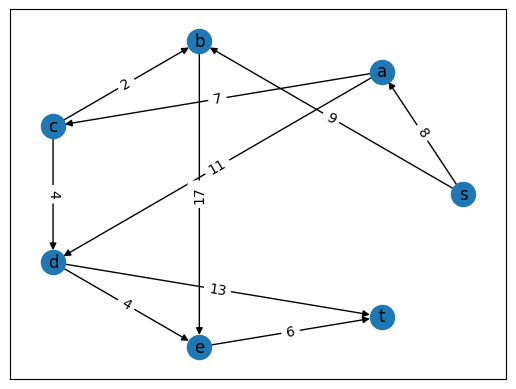

In [12]:
G = nx.DiGraph()
v = ["s","a","b","c","d","e",'t']
G.add_nodes_from(v)
G.add_edge("s", "a", weight = 8)
G.add_edge("s", "b", weight = 9)
G.add_edge("a", "c", weight = 7)
G.add_edge("a", "d", weight = 11)
G.add_edge("b", "e", weight = 17)
G.add_edge("c", "b", weight = 2)
G.add_edge("c", "d", weight = 4)
G.add_edge("d", "t", weight = 13)
G.add_edge("d", "e", weight = 4)
G.add_edge("e", "t", weight = 6)
pos = nx.circular_layout(G)
nx.draw_networkx(G, pos, with_labels=True)
edge_labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels)

In [18]:
hossz, rovid_ut = nx.single_source_dijkstra(G, "s", "t")
#hossz, rovid_ut = nx.single_source_dijkstra(G, "s", "t", weight = None)

print('A legrövidebb út:', rovid_ut)
print('A legrövidebb út hossza: ', hossz)

A legrövidebb út: ['s', 'a', 'd', 'e', 't']
A legrövidebb út hossza:  29


In [14]:
rovidut_LP = pulp.LpProblem('Legrövidebb_út', LpMaximize)

x = LpVariable.dicts('x',v,cat="Continuous")

rovidut_LP += x["t"]

d = nx.get_edge_attributes(G, 'weight')
elek = list(G.edges())

for i in range(len(elek)):
    rovidut_LP += x[elek[i][1]] - x[elek[i][0]] <= d[elek[i][0], elek[i][1]]

rovidut_LP += x["s"] == 0

megoldas = rovidut_LP.solve()

print(LpStatus[megoldas])
print('Legrövidebb út hossza: z* = ', value(rovidut_LP.objective))
for v in rovidut_LP.variables():
    print (v.name, "=", v.varValue)

Optimal
Legrövidebb út hossza: z* =  29.0
x_a = 8.0
x_b = 6.0
x_c = 15.0
x_d = 19.0
x_e = 23.0
x_s = 0.0
x_t = 29.0


In [15]:
i=0
for name, c in rovidut_LP.constraints.items():
    print('y'+str(elek[i])+' =', c.pi)
    i += 1
    if (i == len(elek)):
        break

y('s', 'a') = 1.0
y('s', 'b') = -0.0
y('a', 'c') = -0.0
y('a', 'd') = 1.0
y('b', 'e') = -0.0
y('c', 'b') = -0.0
y('c', 'd') = -0.0
y('d', 't') = -0.0
y('d', 'e') = 1.0
y('e', 't') = 1.0


In [16]:
rovidut_LP += x["c"] - x["t"]

rovidut_LP += x["a"] - x["s"] == 8
rovidut_LP += x["d"] - x["a"] == 11
rovidut_LP += x["e"] - x["d"] == 4
rovidut_LP += x["t"] - x["e"] == 6

megoldas = rovidut_LP.solve()

print(LpStatus[megoldas])
print('C és T távolsága legfeljebb, hogy része legyen a legrövidebb útnak:', -value(rovidut_LP.objective))

Optimal
C és T távolsága legfeljebb, hogy része legyen a legrövidebb útnak: 14.0
